# SA-GAN XRAY

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
from cleanfid import fid
#import cv2

In [3]:
#!pip install clean-fid

In [4]:
loss_g_per_batch = []
loss_d_per_batch = []
loss_g = []
loss_d = []
real_score_per_batch = []
fake_score_per_batch = []
real_score = []
fake_score = []
loss_g_per_batch = np.genfromtxt('logs/loss_g_per_batch.txt')
loss_d_per_batch = np.genfromtxt('logs/loss_d_per_batch.txt')
loss_g = np.genfromtxt('logs/losses_g.txt')
loss_d = np.genfromtxt('logs/losses_d.txt')
real_score_per_batch = np.genfromtxt('logs/real_score_per_batch.txt')
fake_score_per_batch = np.genfromtxt('logs/fake_score_per_batch.txt')
real_score = np.genfromtxt('logs/real_scores.txt')
fake_score = np.genfromtxt('logs/fake_scores.txt')

In [5]:
x_batch=np.arange(1,loss_g_per_batch.shape[0]+1)
x = np.arange(1,loss_g.shape[0]+1)

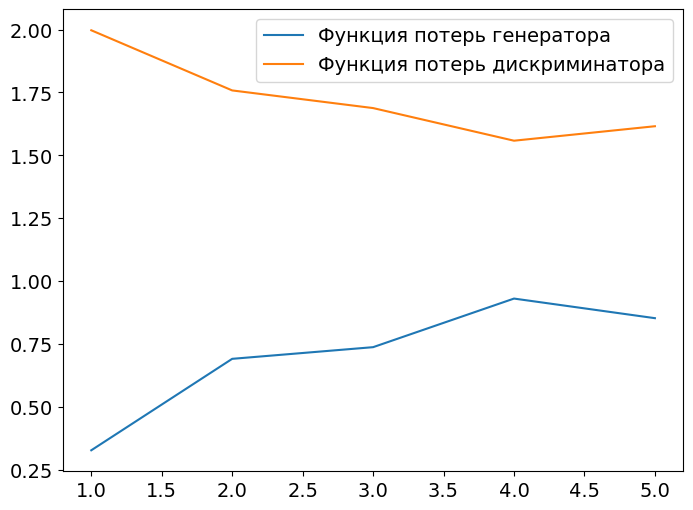

In [6]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, loss_g, label='Функция потерь генератора')
plt.plot(x, loss_d, label='Функция потерь дискриминатора')
plt.legend()

plt.show()

In [6]:
len(x_batch)

5765

In [ ]:
print(len(np.linspace(0,50000,40)))
len(loss_g_per_batch[-50000:].reshape(-1,1000).mean(axis=1))

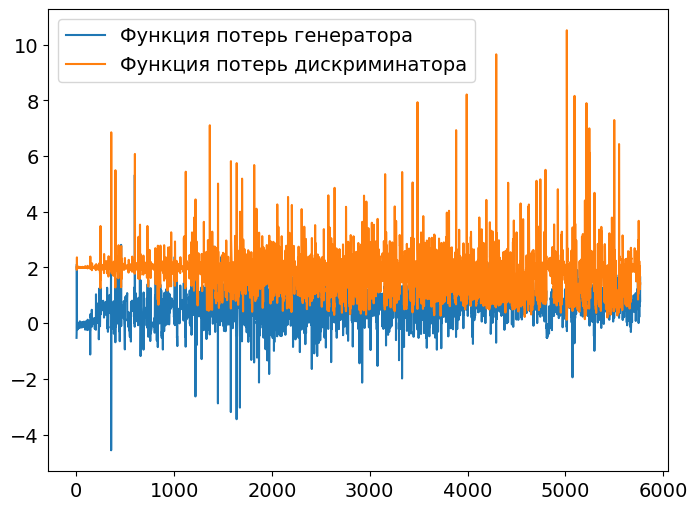

In [7]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.plot(x_batch, loss_g_per_batch, label='Функция потерь генератора')
plt.plot(x_batch, loss_d_per_batch, label='Функция потерь дискриминатора')
plt.legend()

plt.show()


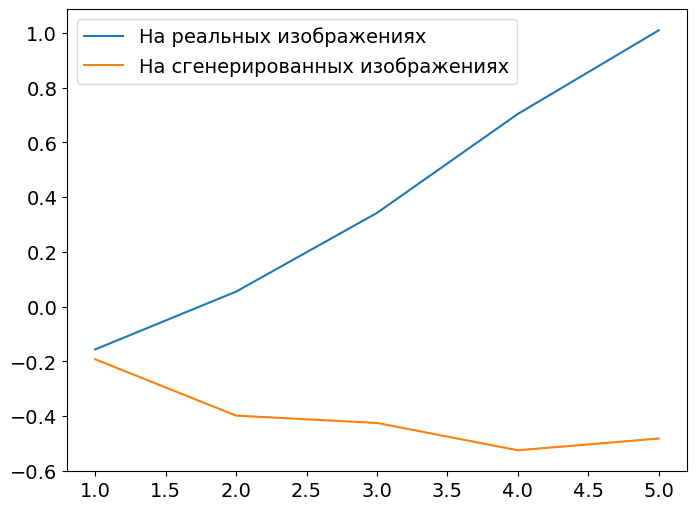

In [8]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, real_score, label='На реальных изображениях')
plt.plot(x, fake_score, label='На сгенерированных изображениях')
plt.legend()

plt.show()

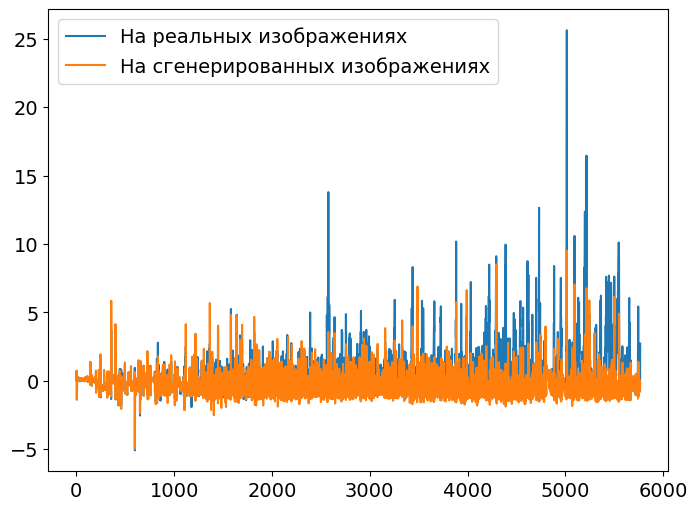

In [9]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x_batch, real_score_per_batch, label='На реальных изображениях')
plt.plot(x_batch, fake_score_per_batch, label='На сгенерированных изображениях')
plt.legend()

plt.show()

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.functional as F
import functools
from torch.nn.parallel import DistributedDataParallel as DDP
import re
from collections import OrderedDict

img_size=256
n_channels=1

latent_size=128
batch_size=6

# 128 никуда не влезет, нужно меньше.
step_conv_channels=32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

beta1 = 0.0 
beta2 = 0.999

lr={
    'generator': 0.000025,
    'discriminator': 0.000025
}

class Self_Attention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out
    
class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=None, channel_ratio=4):
        super(GBlock, self).__init__()
        
        self.in_channels, self.out_channels = in_channels, out_channels
        hidden_channels = in_channels // channel_ratio
        self.upsample = upsample
        
        self.activation = nn.ReLU()
        
        # я не уверен, что это верно, https://github.com/ajbrock/BigGAN-PyTorch/blob/master/layers.py#L111 -- тут 
        # не понятно что происходит, будто бы спектральная нормализация применяется перед применением свёртки
        # но я не уверен.... Сделаю как было в SAGAN, ведь в статье сказано, что всё так же.
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, hidden_channels, kernel_size = 1, padding = 0))
        self.conv2 = spectral_norm(nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, padding = 1))
        self.conv3 = spectral_norm(nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, padding = 1))
        self.conv4 = spectral_norm(nn.Conv2d(hidden_channels, out_channels, kernel_size = 1, padding = 0))
        
        # используется обычный батчнорм. ВАЖНО! если использовать на нескольких устройствах (распараллелить),
        # статистика будет считаться внутри каждого устройства, а не по всем устройствам, поэтому
        # она может быть не точной.
        # Также попробуем не использовать условную нормализацию.
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        self.bn3 = nn.BatchNorm2d(hidden_channels)
        self.bn4 = nn.BatchNorm2d(hidden_channels)
    
    # не подаём y (класс + случайный вектор), попробуем без него
    def forward(self, x):
        h = self.conv1(self.activation(self.bn1(x)))
        h = self.activation(self.bn2(h))
        
        if self.in_channels != self.out_channels:
            x = x[:, :self.out_channels]
        
        if self.upsample:
            h = self.upsample(h)
            x = self.upsample(x)
            
        h = self.conv2(h)
        h = self.conv3(self.activation(self.bn3(h)))
        h = self.conv4(self.activation(self.bn4(h)))
        
        return x + h
    
class Generator(nn.Module):
    def __init__(self, encoding_dims = 128, step_channels = 128):
        super(Generator, self).__init__()
        
        self.linear = spectral_norm(nn.Linear(encoding_dims, 4 * 4 * 16 * step_channels))
        
        self.blocks = nn.Sequential(
            GBlock(16 * step_channels, 16 * step_channels, upsample = None),
            GBlock(16 * step_channels, 16 * step_channels, upsample = functools.partial(F.interpolate, scale_factor=2)),
            GBlock(16 * step_channels, 16 * step_channels, upsample = None),
            GBlock(16 * step_channels, 8 * step_channels, upsample = functools.partial(F.interpolate, scale_factor=2)),
            GBlock(8 * step_channels, 8 * step_channels, upsample = None),
            GBlock(8 * step_channels, 8 * step_channels, upsample = functools.partial(F.interpolate, scale_factor=2)),
            GBlock(8 * step_channels, 8 * step_channels, upsample = None),
            GBlock(8 * step_channels, 4 * step_channels, upsample = functools.partial(F.interpolate, scale_factor=2)),
            Self_Attention(4 * step_channels),
            GBlock(4 * step_channels, 4 * step_channels, upsample = None),
            GBlock(4 * step_channels, 2 * step_channels, upsample = functools.partial(F.interpolate, scale_factor=2)),
            GBlock(2 * step_channels, 2 * step_channels, upsample = None),
            GBlock(2 * step_channels, step_channels, upsample = functools.partial(F.interpolate, scale_factor=2))
        )
        
        self.output_layer = nn.Sequential(
            nn.BatchNorm2d(step_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(step_channels, 1, kernel_size = 3, padding = 1)),
            nn.Tanh()
        )
        
    def forward(self, z):
        z = z.view(z.size(0),-1)
        h = self.linear(z)
        h = h.view(h.size(0), -1, 4, 4)
        h = self.blocks(h)
        h = self.output_layer(h)
        
        return h
    
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = None, channel_ratio = 4):
        super(DBlock, self).__init__()
        
        hidden_channels = out_channels // channel_ratio
        
        self.downsample = downsample
        self.activation = nn.ReLU()
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, hidden_channels, kernel_size = 1, padding = 0))
        self.conv2 = spectral_norm(nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, padding = 1))
        self.conv3 = spectral_norm(nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, padding = 1))
        self.conv4 = spectral_norm(nn.Conv2d(hidden_channels, out_channels, kernel_size = 1, padding = 0))
        
        self.learnable_sc = True if (in_channels != out_channels) else False
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels - in_channels, kernel_size = 1, padding = 0))
    
    def shortcut(self, x):
        if self.downsample:
            x = self.downsample(x)
        if self.learnable_sc:
            x = torch.cat([x, self.conv_sc(x)], 1)
        return x
    
    def forward(self, x):
        h = self.conv1(self.activation(x))
        h = self.conv2(self.activation(h))
        h = self.conv3(self.activation(h))
        h = self.activation(h)
        
        if self.downsample:
            h = self.downsample(h)
            
        h = self.conv4(h)
        
        return h + self.shortcut(x)
    
class Discriminator(nn.Module):
    def __init__(self, step_channels):
        super(Discriminator, self).__init__()
        
        self.input_conv = spectral_norm(nn.Conv2d(1, step_channels, kernel_size=3, padding = 1))
        self.activation = nn.ReLU()
        
        self.blocks = nn.Sequential(
            DBlock(step_channels, 2 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(2 * step_channels, 2 * step_channels, downsample = None),
            DBlock(2 * step_channels, 4 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(4 * step_channels, 4 * step_channels, downsample = None),
            Self_Attention(4 * step_channels),
            DBlock(4 * step_channels, 8 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(8 * step_channels, 8 * step_channels, downsample = None),
            DBlock(8 * step_channels, 8 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(8 * step_channels, 8 * step_channels, downsample = None),
            DBlock(8 * step_channels, 16 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(16 * step_channels, 16 * step_channels, downsample = None),
            DBlock(16 * step_channels, 16 * step_channels, downsample = nn.AvgPool2d(2)),
            DBlock(16 * step_channels, 16 * step_channels, downsample = None),
        )
        
        self.linear = nn.Linear(16 * step_channels, 1)
        
    def forward(self, x):
        h = self.input_conv(x)
        h = self.blocks(h)
        h = torch.sum(self.activation(h), [2, 3])
        h = self.linear(h)
        
        return h

In [9]:
generator = Generator(encoding_dims = latent_size, step_channels = step_conv_channels)

summary(generator,(latent_size,1), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       1,056,768
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
            Conv2d-4            [-1, 128, 4, 4]          65,664
       BatchNorm2d-5            [-1, 128, 4, 4]             256
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         147,584
      BatchNorm2d-11            [-1, 128, 4, 4]             256
             ReLU-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]          66,048
           GBlock-14            [-1, 51

In [10]:
discriminator = Discriminator(step_channels = step_conv_channels)

summary(discriminator,(1,img_size,img_size), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 16, 256, 256]             528
              ReLU-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           2,320
              ReLU-6         [-1, 16, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]           2,320
              ReLU-8         [-1, 16, 256, 256]               0
         AvgPool2d-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]           1,088
        AvgPool2d-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           1,056
           DBlock-13         [-1, 64, 128, 128]               0
             ReLU-14         [-1, 64, 1

In [11]:
generator = generator.to(device)
#generator = nn.DataParallel(generator)
#discriminator = discriminator.to(device)
#discriminator = nn.DataParallel(discriminator)

model={
    'generator' : generator,
    #'discriminator' : discriminator
}

In [12]:
def gen_and_save(model, epochs, amount = 32, save=False, batch_size=32):
    model['generator'].eval()
    to_show=None
    with torch.no_grad():
        cnt = amount//batch_size
        for i in range(cnt):
            z = np.array([np.random.normal(0, 1, latent_size) for i in range(batch_size)])

            output = model['generator'](torch.FloatTensor(z).to(device))
            if to_show is None:
                to_show=output
                
            if save:
                if not os.path.isdir('images_{}_epochs'.format(epochs)):
                    os.mkdir('images_{}_epochs'.format(epochs))
                for j in range(batch_size):
                    #save_image((output[j]+1)/2. , 'images_{}_epochs/{}.png'.format(epochs, j+i*batch_size))
                    tmp = ((output[j]+1)/2.*255).permute(1,2,0).numpy()
                    cv2.imwrite('images_{}_epochs/{}.png'.format(epochs, j+i*batch_size), tmp)
                    
        if amount - cnt * batch_size != 0:
            z = np.array([np.random.normal(0, 1, latent_size) for _ in range(amount - cnt * batch_size)])
            
            output = model['generator'](torch.FloatTensor(z).to(device))
            if save:
                if not os.path.isdir('images_{}_epochs'.format(epochs)):
                    os.mkdir('images_{}_epochs'.format(epochs))
                for j in range(amount - cnt * batch_size):
                    #save_image((output[j]+1)/2. , 'images_{}_epochs/{}.png'.format(epochs, j+cnt*batch_size))
                    tmp = ((output[j]+1)/2.*255).permute(1,2,0).numpy()
                    cv2.imwrite('images_{}_epochs/{}.png'.format(epochs, j+cnt*batch_size), tmp)

    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.title("Generated Images %d epochs" %epochs)
    plt.imshow(np.transpose(make_grid(to_show.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [19]:
def calculate_fid(model, n_images = 1000, rearrange = False, batch_size=64):
    if not os.path.isdir('generated'):
        os.mkdir('generated')
    else:
        if len([name for name in os.listdir('generated')]) != n_images or rearrange:
            folderPath = 'generated'
            for file in os.listdir(folderPath):
                fullFilePath = folderPath + "/" + file
                os.remove(fullFilePath)
                
    if len([name for name in os.listdir('generated')]) != n_images or rearrange:    
        model['generator'].eval()
        with torch.no_grad():
            cnt = n_images//batch_size
            for i in tqdm(range(cnt)):
                z = np.array([np.random.normal(0, 1, latent_size) for k in range(batch_size)])
                output = model['generator'](torch.FloatTensor(z).to(device))
                for j in range(batch_size):
                    save_image((output[j]+1)/2., 'generated/%d.png' % (i * batch_size + j))
            if n_images - cnt * batch_size != 0:
                z = np.array([np.random.normal(0, 1, latent_size) for i in range(n_images - cnt * batch_size)])
                output = model['generator'](torch.FloatTensor(z).to(device))
                for j in range(n_images - cnt * batch_size):
                    save_image((output[j]+1)/2., 'generated/%d.png' % (cnt * batch_size + j))
    #if on cpu num_workers should be >0
    score = fid.compute_fid('CT_c02_90K+', 'generated', mode = 'clean', num_workers = 4, device = device)
    return score

In [20]:
def load_model(model, epoch):
    model_dict = OrderedDict()
    state_dict = torch.load('weights/generator_epoch_%d.pth' %epoch, map_location=torch.device(device))
    pattern = re.compile('module.')
    for k,v in state_dict.items():
        if re.search("module", k):
            model_dict[re.sub(pattern, '', k)] = v    
        else:
            model_dict = state_dict
        
    model['generator'].load_state_dict(model_dict)
    